# Derivative Pricing

In [4]:
#Load Package

import numpy as np
import matplotlib.pyplot as plt

## Binomial Tree

Inputs: 

    S_{ini} - Initial stock price
    
    T - time-horizon
    
    u - upward
    
    d - downward
    
    N - # of steps

In [6]:
def binomial_tree(S_ini, T, u, d, N):
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return S

In [7]:
Stock = binomial_tree(100, 1, 1.2, 0.8, 2)
Stock

array([[100.,   0.,   0.],
       [ 80., 120.,   0.],
       [ 64.,  96., 144.]])

### Binomial Tree w/ Call Option Payoffs

Additional input: 

    K - strike price
    r - risk-free rate
    
Call Payoff:

    Max(S_t - K; 0)

Risk-Neutral Probabilities and Backward induction of Call Option value

Value of call option at each node:

    C_t = e^{-r dt} [p c^u_{t+1} + (1-p) c^d_{t+1}]
    
Risk neutral probability:

    p=\frac{e^{rdt}-d}{u-d}

In [8]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probabilities (probs)
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        C[N, i] = max(S[N, i] - K, 0)
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
    return C[0, 0], C, S

In [9]:
call_price, C, S = binomial_call_full(100, 90, 10, 0, 1.2, 0.8, 2)
print("Underlying Price Evolution:\n", S)
print("Call Option Payoff:\n", C)
print("Call Option Price at t=0: ", "{:.2f}".format(call_price))

Underlying Price Evolution:
 [[100.   0.   0.]
 [ 80. 120.   0.]
 [ 64.  96. 144.]]
Call Option Payoff:
 [[16.5  0.   0. ]
 [ 3.  30.   0. ]
 [ 0.   6.  54. ]]
Call Option Price at t=0:  16.50


### Binomial Tree w/ Put Option Payoffs
    
Call Payoff:

    Max(K - S_t; 0)

In [10]:
def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        P[N, i] = max(K - S[N, i], 0)
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
    return P[0, 0], P, S

In [11]:
put_price, P, S = binomial_put_full(100, 90, 10, 0, 1.2, 0.8, 2)
print("Underlying Price Evolution:\n", S)
print("Put Option Payoff:\n", P)
print("Price at t=0 for Put option is$", "{:.2f}".format(put_price))

Underlying Price Evolution:
 [[100.   0.   0.]
 [ 80. 120.   0.]
 [ 64.  96. 144.]]
Put Option Payoff:
 [[ 6.5  0.   0. ]
 [13.   0.   0. ]
 [26.   0.   0. ]]
Price at t=0 for Put option is$ 6.50


### Put-Call Parity in Binomial Tree

The relationship between put and call must be:

    C_0 + K e^{-rT} = S_0 + P_0

In [12]:
K = 90
r = 0
T = 10

# At t=0
t0 = round(C[0, 0] + K * np.exp(-r * T), 2) == round(S[0, 0] + P[0, 0], 2)
print(t0)

# At t=1, on path "d"
t1d = round(C[1, 0] + K * np.exp(-r * T), 2) == round(S[1, 0] + P[1,0], 2)
print(t1d)

True
True


### Delta Hedging in Binomial Tree

Additional output:

    $Delta_t$ - No. of underlying in terms of exposure

In [13]:
def call_option_delta(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        C[N, i] = max(S[N, i] - K, 0)
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i])
            
    return C[0, 0], C, S, Delta

In [14]:
price, call, S, delta = call_option_delta(100, 90, 10, 0, 1.2, 0.8, 2)
print("Underlying: \n", S)
print("Call Price: \n", call)
print("Delta: \n", delta)

Underlying: 
 [[100.   0.   0.]
 [ 80. 120.   0.]
 [ 64.  96. 144.]]
Call Price: 
 [[16.5  0.   0. ]
 [ 3.  30.   0. ]
 [ 0.   6.  54. ]]
Delta: 
 [[0.675  0.    ]
 [0.1875 1.    ]]


Relationship of call option price with N

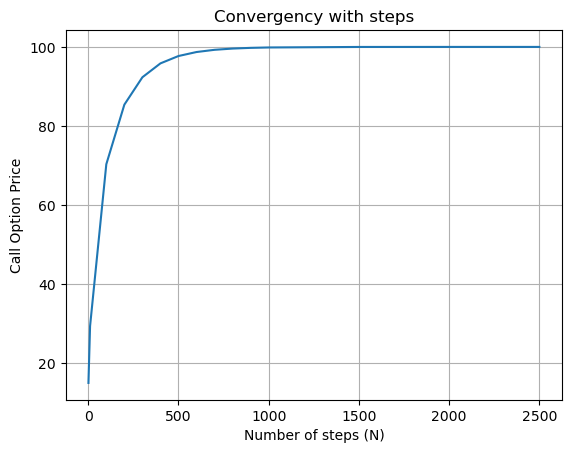

In [16]:
price_array = []
N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]

for n in N:
    price, call, S, delta = call_option_delta(100, 90, 1, 0, 1.2, 0.8, n)
    price_array.append(price)
    
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Call Option Price")
plt.grid(True)
plt.show()

### Adjusting u and d for Underlying Volatility

The adjustment will lead to:

u = exp{\sigma \sqrt{dt}}    &  d = exp{-\sigma \sqrt{dt}}

In [17]:
def call_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        C[N, i] = max(S[N, i] - K, 0)
                
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i])
    return C[0, 0], C, S, Delta

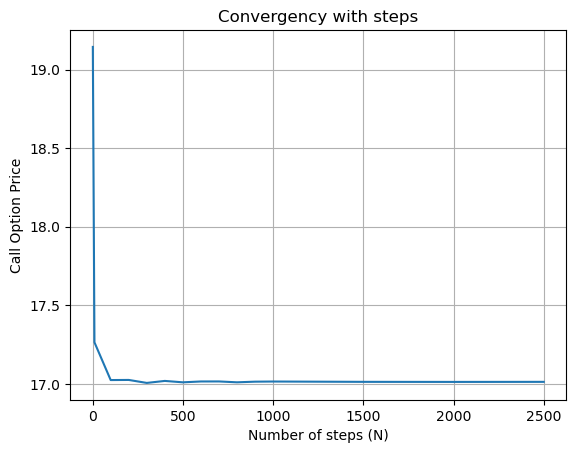

In [19]:
price_array = []
N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]

for n in N:
    price, call, S, delta = call_option_delta(100, 90, 1, 0, 0.3, n)
    price_array.append(price)
    
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Call Option Price")
plt.grid(True)
plt.show()